In [17]:
import pickle
import pandas as pd
import seaborn as sns

In [18]:
air_df = pickle.load(open("air_df_1.p",'rb'))
open('air_df_1.p','rb').close

<function BufferedReader.close>

In [19]:
air_df.sort_values(by='Date',inplace=True)
df =air_df[['Date','Daily Max 8-hour Ozone Concentration']]
df.set_index('Date',inplace=True)

In [21]:
pred_scaler = MinMaxScaler(feature_range = (0, 1))
pred_scaler = pred_scaler.fit(np.array(df['Daily Max 8-hour Ozone Concentration']).reshape(-1, 1))

In [22]:
import plaidml.keras
plaidml.keras.install_backend()

from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

In [23]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
# load dataset
values = df.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
# drop columns we don't want to predict
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.246377,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870
8,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478
9,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493
10,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942
11,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899


In [26]:
y = reframed.iloc[:,-1].values
X = reframed.drop(['var1(t)'], axis =1).values
# split into train and test sets

n_train_days = 3100
n_test_days=360
train_X = X[:n_train_days,:]
train_y = y[:n_train_days]

val_X= X[n_train_days:-n_test_days,]
val_y= y[n_train_days:-n_test_days]

test_X = X[-n_test_days:,:]
test_y = y[-n_test_days:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(3100, 1, 7) (3100,) (505, 1, 7) (505,) (360, 1, 7) (360,)


Train on 3100 samples, validate on 505 samples
Epoch 1/200
 - 0s - loss: 0.2055 - val_loss: 0.1011
Epoch 2/200
 - 0s - loss: 0.1003 - val_loss: 0.0918
Epoch 3/200
 - 0s - loss: 0.0924 - val_loss: 0.0848
Epoch 4/200
 - 0s - loss: 0.0862 - val_loss: 0.0788
Epoch 5/200
 - 0s - loss: 0.0810 - val_loss: 0.0753
Epoch 6/200
 - 0s - loss: 0.0776 - val_loss: 0.0715
Epoch 7/200
 - 0s - loss: 0.0748 - val_loss: 0.0690
Epoch 8/200
 - 0s - loss: 0.0726 - val_loss: 0.0675
Epoch 9/200
 - 0s - loss: 0.0709 - val_loss: 0.0661
Epoch 10/200
 - 0s - loss: 0.0697 - val_loss: 0.0649
Epoch 11/200
 - 0s - loss: 0.0689 - val_loss: 0.0644
Epoch 12/200
 - 0s - loss: 0.0684 - val_loss: 0.0657
Epoch 13/200
 - 0s - loss: 0.0681 - val_loss: 0.0639
Epoch 14/200
 - 0s - loss: 0.0677 - val_loss: 0.0636
Epoch 15/200
 - 0s - loss: 0.0674 - val_loss: 0.0649
Epoch 16/200
 - 0s - loss: 0.0675 - val_loss: 0.0644
Epoch 17/200
 - 0s - loss: 0.0672 - val_loss: 0.0635
Epoch 18/200
 - 0s - loss: 0.0672 - val_loss: 0.0634
Epoch 19

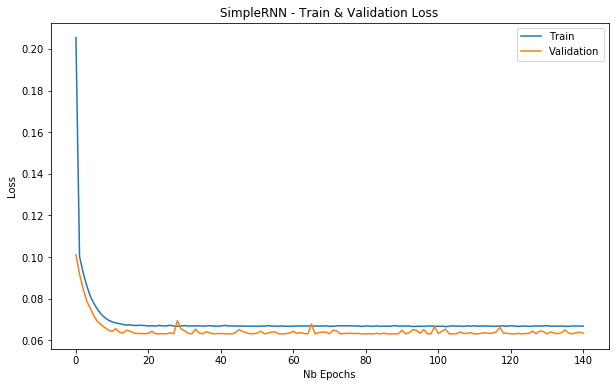

Minimum validation loss of 0.06311377217568974 reached at epoch 110


In [27]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(5, input_shape=(train_X.shape[1], train_X.shape[2])))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

#checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5'
#                               , verbose=0
#                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)
with open("simple_rnn.json", "w") as m:
     m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit(train_X,train_y
                                              , epochs=200
                                              , validation_data=(val_X, val_y)
                                              , verbose=2
                                              , callbacks= [earlystopper]
                                             )
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

Train on 3100 samples, validate on 505 samples
Epoch 1/200
 - 1s - loss: 0.3076 - val_loss: 0.1430
Epoch 2/200
 - 1s - loss: 0.0929 - val_loss: 0.0812
Epoch 3/200
 - 1s - loss: 0.0811 - val_loss: 0.0763
Epoch 4/200
 - 1s - loss: 0.0771 - val_loss: 0.0726
Epoch 5/200
 - 1s - loss: 0.0743 - val_loss: 0.0701
Epoch 6/200
 - 1s - loss: 0.0725 - val_loss: 0.0696
Epoch 7/200
 - 1s - loss: 0.0711 - val_loss: 0.0685
Epoch 8/200
 - 1s - loss: 0.0700 - val_loss: 0.0663
Epoch 9/200
 - 1s - loss: 0.0691 - val_loss: 0.0658
Epoch 10/200
 - 1s - loss: 0.0687 - val_loss: 0.0652
Epoch 11/200
 - 0s - loss: 0.0679 - val_loss: 0.0654
Epoch 12/200
 - 1s - loss: 0.0678 - val_loss: 0.0647
Epoch 13/200
 - 1s - loss: 0.0677 - val_loss: 0.0645
Epoch 14/200
 - 1s - loss: 0.0675 - val_loss: 0.0640
Epoch 15/200
 - 1s - loss: 0.0675 - val_loss: 0.0638
Epoch 16/200
 - 1s - loss: 0.0673 - val_loss: 0.0638
Epoch 17/200
 - 1s - loss: 0.0672 - val_loss: 0.0640
Epoch 18/200
 - 1s - loss: 0.0672 - val_loss: 0.0641
Epoch 19

Epoch 154/200
 - 1s - loss: 0.0667 - val_loss: 0.0631
Epoch 155/200
 - 1s - loss: 0.0667 - val_loss: 0.0632
Epoch 156/200
 - 1s - loss: 0.0664 - val_loss: 0.0638
Epoch 157/200
 - 1s - loss: 0.0666 - val_loss: 0.0631
Epoch 158/200
 - 1s - loss: 0.0666 - val_loss: 0.0638
Epoch 159/200
 - 1s - loss: 0.0666 - val_loss: 0.0632
Epoch 160/200
 - 1s - loss: 0.0666 - val_loss: 0.0631
Epoch 161/200
 - 1s - loss: 0.0666 - val_loss: 0.0632
Epoch 162/200
 - 1s - loss: 0.0666 - val_loss: 0.0631
Epoch 163/200
 - 1s - loss: 0.0665 - val_loss: 0.0634
Epoch 164/200
 - 1s - loss: 0.0666 - val_loss: 0.0637
Epoch 165/200
 - 1s - loss: 0.0666 - val_loss: 0.0638
Epoch 166/200
 - 1s - loss: 0.0667 - val_loss: 0.0657
Epoch 167/200
 - 1s - loss: 0.0667 - val_loss: 0.0632
Epoch 168/200
 - 1s - loss: 0.0667 - val_loss: 0.0632
Epoch 169/200
 - 1s - loss: 0.0665 - val_loss: 0.0635
Epoch 170/200
 - 1s - loss: 0.0665 - val_loss: 0.0633
Epoch 171/200
 - 1s - loss: 0.0666 - val_loss: 0.0646
Epoch 172/200
 - 1s - loss: 

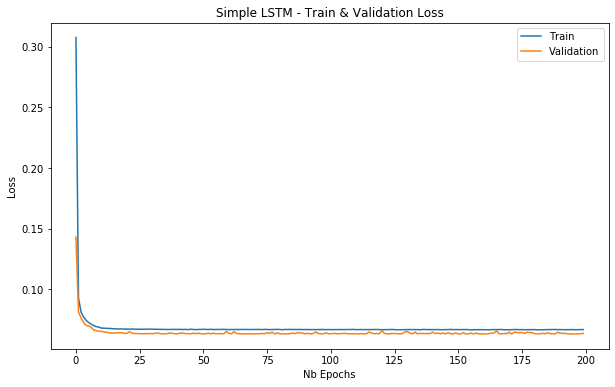

Minimum validation loss of 0.06305232543756466 reached at epoch 196


In [28]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

#checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
#                               , verbose=0
#                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)
with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit(train_X,train_y
                                              , epochs=200
                                              , validation_data=(val_X, val_y)
                                              , verbose=2
                                              , callbacks= [earlystopper]
                                             )
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

Train on 3100 samples, validate on 505 samples
Epoch 1/200
 - 1s - loss: 0.2505 - val_loss: 0.0883
Epoch 2/200
 - 1s - loss: 0.0839 - val_loss: 0.0781
Epoch 3/200
 - 1s - loss: 0.0794 - val_loss: 0.0741
Epoch 4/200
 - 1s - loss: 0.0767 - val_loss: 0.0721
Epoch 5/200
 - 1s - loss: 0.0747 - val_loss: 0.0701
Epoch 6/200
 - 1s - loss: 0.0734 - val_loss: 0.0686
Epoch 7/200
 - 1s - loss: 0.0722 - val_loss: 0.0676
Epoch 8/200
 - 1s - loss: 0.0711 - val_loss: 0.0704
Epoch 9/200
 - 1s - loss: 0.0702 - val_loss: 0.0658
Epoch 10/200
 - 1s - loss: 0.0693 - val_loss: 0.0654
Epoch 11/200
 - 1s - loss: 0.0689 - val_loss: 0.0649
Epoch 12/200
 - 1s - loss: 0.0683 - val_loss: 0.0647
Epoch 13/200
 - 1s - loss: 0.0682 - val_loss: 0.0642
Epoch 14/200
 - 1s - loss: 0.0682 - val_loss: 0.0645
Epoch 15/200
 - 1s - loss: 0.0681 - val_loss: 0.0639
Epoch 16/200
 - 1s - loss: 0.0680 - val_loss: 0.0639
Epoch 17/200
 - 1s - loss: 0.0677 - val_loss: 0.0639
Epoch 18/200
 - 1s - loss: 0.0675 - val_loss: 0.0637
Epoch 19

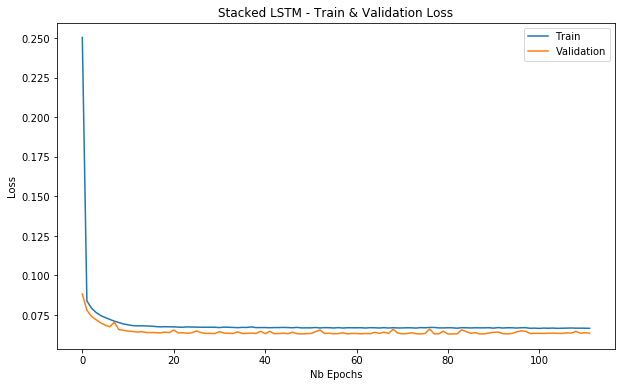

Minimum validation loss of 0.06303374998935378 reached at epoch 81


In [29]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

#checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
#                               , verbose=0
#                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit(train_X,train_y
                                              , epochs=200
                                              , validation_data=(val_X, val_y)
                                              , verbose=2
                                              , callbacks= [earlystopper]
                                             )
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

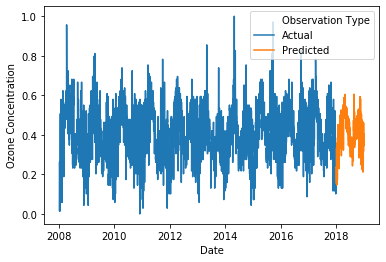

In [30]:
preds = []
preds_array = stacked_lstm.predict(test_X)
for i in range(len(preds_array)):
    preds.append(preds_array[i][0])

train_data = pd.DataFrame({
    'Ozone Concentration':train_y,
    'Date':df.index[7:3107]
})
train_data['Observation Type'] = 'Actual'

val_data = pd.DataFrame({
    'Ozone Concentration':val_y,
    'Date':df.index[3107:-360]
})
val_data['Observation Type'] = 'Actual'

test_data = pd.DataFrame({
    'Ozone Concentration':preds,
    'Date':df.index[-360:]
})
test_data['Observation Type'] = 'Predicted'

plot_me = pd.concat([train_data,val_data,test_data])
plot_me['Ozone Concentration'] = pred_scaler.inverse_transform(np.array(plot_me['Ozone Concentration']).reshape(-1, 1))
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])

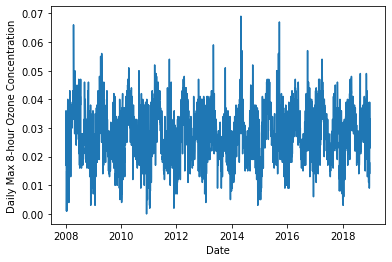

In [31]:
sns.lineplot(x=df.index,y=df['Daily Max 8-hour Ozone Concentration'])

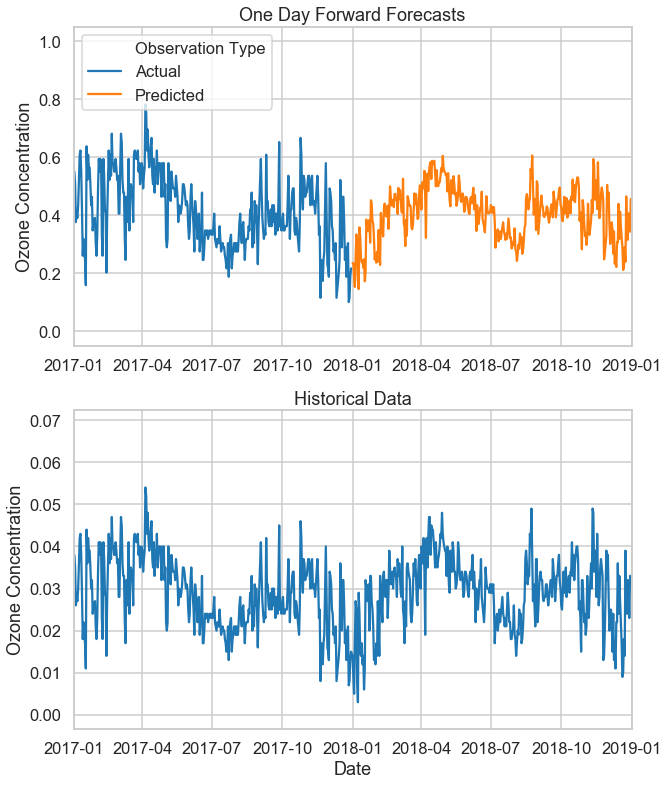

In [39]:
sns.set_style('whitegrid')
sns.set_context('talk')


plt.figure(figsize=(10,2))


plt.subplot(2,1,2)
plt.title('Historical Data')
sns.lineplot(x=df.index,y=df['Daily Max 8-hour Ozone Concentration'])
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))   
plt.ylabel('Ozone Concentration')


plt.subplot(2,1,1)
plt.title('One Day Forward Forecasts')
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])
plt.legend(loc='upper left')
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))  
plt.ylabel('Ozone Concentration')
plt.subplots_adjust(left=None, bottom= -4, right=None, top=None, wspace=None, hspace=None)
plt.xlabel('')


plt.savefig('forecasts/single1day.png',bbox_inches="tight")